In [3]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [4]:
from MOO_func import *

In [5]:
GM_sun = 1.3271244*1e20 #   这个式子等于  G * M_sun
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16

Mpc = (10**6) * pc

In [6]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
# from few.utils.utility import omp_set_num_threads
# omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

725418


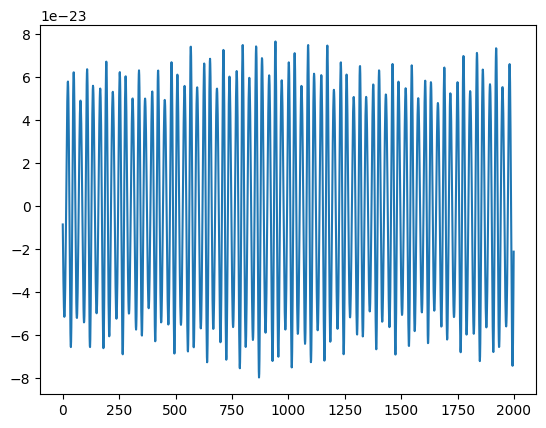

In [7]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

# parameters
T = 0.5  # years
dt = 10  # seconds
M = 5e5
a = 0.98
mu = 50
p0 = 11.0
e0 = 0.1
x0 = 0.7  # notice this is x_I, not Y. The AAK waveform can convert to Y. 
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 10# distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h.real[:2000])
plt.show

# temp=h[:2000]
# h=temp
print(len(h))

In [8]:
para=np.array([M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,T,dt])
print(para)
temp=str(para)
with open('parametersAAK_PN5.txt', 'w') as f:
    f.write(temp)

[5.0e+05 5.0e+01 9.8e-01 1.1e+01 1.0e-01 7.0e-01 1.0e+01 3.0e-01 3.0e-01
 2.0e-01 2.0e-01 1.0e+00 2.0e+00 3.0e+00 5.0e-01 1.0e+01]


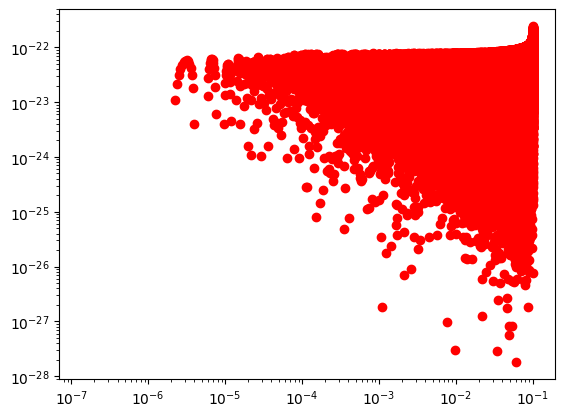

: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft,fftfreq
import math
from math import pi as Pi



para=np.array([M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,T,dt])
temp=para
para=[float(x) for x in temp]
# temp=h[-10000:]
# h=temp
wave1 = np.array(h)
f = np.array(np.arange(len(h))/dt/ len(h))
plt.loglog(f,wave1.real,'ro')
plt.show()

tukey_seq=[tukey(i,len(h),1/8) for i in range(0,len(h))]
wave1 = tukey_seq*wave1

waveform1 = fft(wave1)
waveform2 = np.column_stack((waveform1, f))
temp=waveform2.real*waveform2.real+waveform2.imag*waveform2.imag
waveform = np.sqrt(temp)


plt.loglog(f, np.abs(waveform1), 'ro')
plt.show()

np.savetxt("waveform.txt", waveform, fmt="%50.50f", delimiter=" ")

import re
with open('waveform.txt', 'r') as f:
    text = f.read()
    patn = re.sub(r"[\([{})\]]", "", text)

with open('waveformAAK_PN5.txt', 'w') as f:
    f.write(patn)



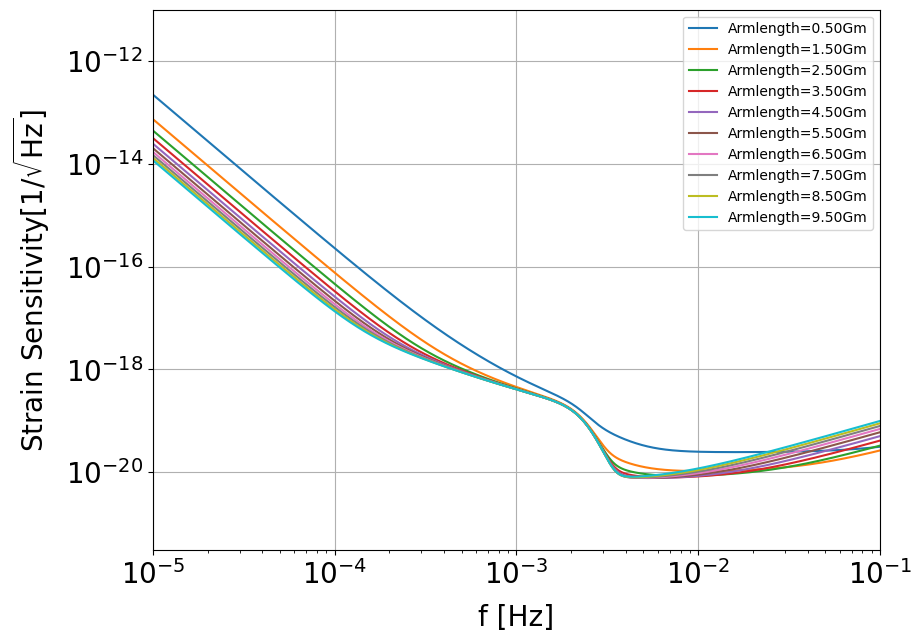

In [8]:
#画灵敏度曲线图
def PlotSensitivityCurve(f,h,PSD,L1,L2,dL,figure_file=None):
    """ 
    Plot the characteristic strain the sensitivity curve 
    
    If figure_file is provided, the figure will be saved
    """
    
    fig, ax = plt.subplots(1, figsize=(8,6))
    plt.tight_layout()

    ax.set_xlabel(r'f [Hz]', fontsize=20, labelpad=10)
    ax.set_ylabel(r'Strain Sensitivity[$1/\sqrt{\mathrm{Hz}}$]', fontsize=20, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    ax.set_xlim(1.0e-5, 1.0e-1)
    ax.set_ylim(3.0e-22, 1.0e-11)
    
    df=f[1]-f[0]

    while L1<L2:
        PSD_seq=PSD(f,L1)
        L1_Gm=L1/1e9
        ax.loglog(f, np.sqrt(PSD_seq),label='Armlength=%.2fGm'%L1_Gm) # plot the characteristic strain
        plt.legend(loc='upper right')
        
        L1=L1+dL
    plt.grid(True)
    plt.show()
    
    if (figure_file != None):
        plt.savefig(figure_file)
        
    return

data=np.loadtxt(r'waveformAAK_PN5.txt')
freq=data[1:len(data[:,1]),1]
h_local=data[1:len(data[:,0]),0]
PlotSensitivityCurve(freq,h_local,PSD_armlength_dependent,5*10**8,10*10**9,10*10**8)


In [9]:
data=np.loadtxt(r'waveformAAK_PN5.txt')
freq=data[1:len(data[:,1]),1]
h_local=data[1:len(data[:,0]),0]
L1=1*10**8
L2=10*10**9
dL=1*10**8
l1=200
l2=1200
dl=50
SNRlist=SNR_for_diff_para(freq,h_local,PSD_L_lambda,L1,L2,dL,l1,l2,dl,figure_file=None)
#print(np.arange(L1,L2,dL))
#print(SNRlist)

KeyboardInterrupt: 

In [ ]:
print(SNRlist.shape,SNRlist)
np.savetxt("SNRlist.txt", SNRlist, fmt="%50.50f", delimiter=" ")

(99, 20) [[ 0.57595666  0.71417928  0.84711446 ...  1.78594309  1.79516924
   1.80114142]
 [ 1.15087261  1.42698389  1.69245713 ...  3.560013    3.57797898
   3.58947841]
 [ 1.7252481   2.13889615  2.53637341 ...  5.31242339  5.3381262
   5.35423625]
 ...
 [32.76404668 36.59342028 38.83750963 ... 31.25204785 30.63466161
  30.04759656]
 [32.85471415 36.65550755 38.86720402 ... 31.15043659 30.53386003
  29.94772641]
 [32.94231656 36.71427645 38.89362601 ... 31.04853537 30.43281111
  29.84764459]]


In [ ]:
print(np.arange(L1,L2,dL).shape, np.arange(l1,l2,dl).shape)

(99,) (20,)


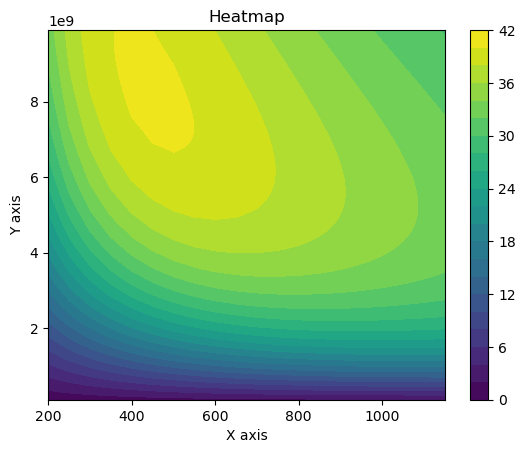

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata


x = np.arange(L1,L2,dL)
y = np.arange(l1,l2,dl) 
z = SNRlist 

# 创建网格数据
# xi = np.linspace(min(x), max(x),len(x))/1e9
# yi = np.linspace(min(y), max(y),len(y))
xi, yi = np.meshgrid(y, x)
#print(xi,yi)
X=[]
Y=[]
Z=[]
# for i in range(0,len(y)):
#     for j in range(0,len(x)):
#         X=np.append(X,xi[j][i])
#         Y=np.append(Y,yi[j][i])
#         Z=np.append(Z,z[i][j])
# zi = griddata((X, Y), Z, (xi, yi), method='nearest')
# print(zi.shape)
# 创建图形
# fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
# surf=ax.plot_surface(xi,yi,z,facecolors=plt.cm.viridis(z))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim(0,30)
# 绘制曲面
# ax.plot_surface(xi, yi, z, cmap='viridis')
# ax.view_init(elev=30, azim=0)
plt.Figure
#plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.contourf(xi, yi, z, 20, cmap='viridis') 
plt.colorbar()  # 显示颜色条

# 设置标签
# ax.set_ylabel('armlength/Gm')
# ax.set_xlabel('$\lambda$/nm')
# ax.set_zlabel('SNR')
plt.title('Heatmap')
plt.xlabel('X axis')
plt.ylabel('Y axis')
# 显示图形
plt.show()


In [12]:
redshift1=np.loadtxt(r'redshift1.txt')
redshift2=np.loadtxt(r'redshift2.txt')
redshift3=np.loadtxt(r'redshift3.txt')
redshift4=np.loadtxt(r'redshift4.txt')
redshift5=np.loadtxt(r'redshift5.txt')
redshift=np.row_stack((redshift1,redshift2,redshift3,redshift4,redshift5))
print(redshift.shape)

(99, 20)


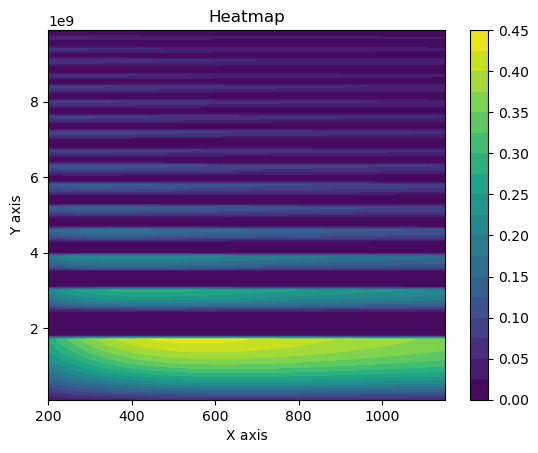

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata


x = np.arange(L1,L2,dL)
y = np.arange(l1,l2,dl) 


z = redshift

# 创建网格数据
# xi = np.linspace(min(x), max(x),len(x))/1e9
# yi = np.linspace(min(y), max(y),len(y))
xi, yi = np.meshgrid(y, x)
#print(xi,yi)
X=[]
Y=[]
Z=[]
# for i in range(0,len(y)):
#     for j in range(0,len(x)):
#         X=np.append(X,xi[j][i])
#         Y=np.append(Y,yi[j][i])
#         Z=np.append(Z,z[i][j])
# zi = griddata((X, Y), Z, (xi, yi), method='nearest')
# print(zi.shape)
# 创建图形
# fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
# surf=ax.plot_surface(xi,yi,z,facecolors=plt.cm.viridis(z))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim(0,30)
# 绘制曲面
# ax.plot_surface(xi, yi, z, cmap='viridis')
# ax.view_init(elev=30, azim=0)
plt.Figure
#plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.contourf(xi, yi, z, 20, cmap='viridis') 
plt.colorbar()  # 显示颜色条

# 设置标签
# ax.set_ylabel('armlength/Gm')
# ax.set_xlabel('$\lambda$/nm')
# ax.set_zlabel('SNR')
plt.title('Heatmap')
plt.xlabel('X axis')
plt.ylabel('Y axis')
# 显示图形
plt.show()


(99, 20)


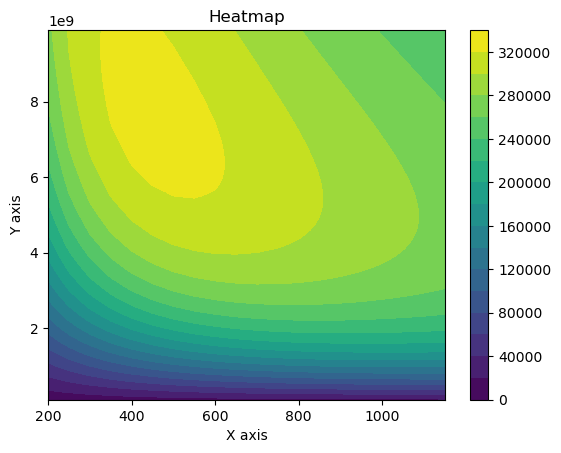

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata


x = np.arange(L1,L2,dL)
y = np.arange(l1,l2,dl) 
SNR_binary =np.loadtxt(r'SNR_binary.txt')

z = SNR_binary[0:99,0:20]
print(z.shape)
# 创建网格数据
# xi = np.linspace(min(x), max(x),len(x))/1e9
# yi = np.linspace(min(y), max(y),len(y))
xi, yi = np.meshgrid(y, x)
#print(xi,yi)
X=[]
Y=[]
Z=[]
# for i in range(0,len(y)):
#     for j in range(0,len(x)):
#         X=np.append(X,xi[j][i])
#         Y=np.append(Y,yi[j][i])
#         Z=np.append(Z,z[i][j])
# zi = griddata((X, Y), Z, (xi, yi), method='nearest')
# print(zi.shape)
# 创建图形
# fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
# surf=ax.plot_surface(xi,yi,z,facecolors=plt.cm.viridis(z))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim(0,30)
# 绘制曲面
# ax.plot_surface(xi, yi, z, cmap='viridis')
# ax.view_init(elev=30, azim=0)
plt.Figure
#plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.contourf(xi, yi, z, 20, cmap='viridis') 
plt.colorbar()  # 显示颜色条

# 设置标签
# ax.set_ylabel('armlength/Gm')
# ax.set_xlabel('$\lambda$/nm')
# ax.set_zlabel('SNR')
plt.title('Heatmap')
plt.xlabel('X axis')
plt.ylabel('Y axis')
# 显示图形
plt.show()


In [ ]:

arm=np.arange(L1,L2,dL)/1e9
max_idx = np.argmax(SNRlist)
max_x, max_y = arm[max_idx], SNRlist[max_idx]
plt.plot(arm,SNRlist,label='SNR with change of armlength')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Armlength[Gm]')
plt.ylabel('SNR')
plt.scatter(max_x, max_y, color='red', s=50)  # 在最大值点上绘制一个红色的圆点
plt.annotate(f'max: ({max_x:.2f}, {max_y:.2f})', xy=(max_x, max_y), xytext=(max_x-1, max_y+0.5),
             arrowprops=dict(facecolor='red', shrink=0.05))  # 添加注释，使用红色箭头连接注释和最大值点
plt.show() 

IndexError: index 1645 is out of bounds for axis 0 with size 99

In [ ]:

#选择一个质量计算探测距离随臂长关系
M_final=10**5
L1=20*10**8
L2=2.5*10**9
dL=1*10**8
l1=200
l2=1200
dl=50
SNR_threshold=10
zseq=np.zeros((len(np.arange(L1,L2,dL)),len(np.arange(l1,l2,dl))))
i=0
j=0
for L in np.arange(L1,L2,dL):
    for l in np.arange(l1,l2,dl):
        f=lambda x:SNR_M_D_L_l_residual(M_final,L,l,SNR_threshold,x)
        zeropoint=Find_zero(f,0.00001,100,0.001,100000)
        if zeropoint>0:
            zseq[i][j]=zeropoint
        j=j+1
    j=0
    i=i+1
        


# max_idx = np.argmax(zseq)
# max_x, max_y = arm[max_idx], zseq[max_idx]

KeyboardInterrupt: 

In [ ]:
t0 =1.
phi0 =0.
fmin = 1e-4

# variables to sample through

Deff = 2 * 1e3 * Mpc
beta = 6
m1 = 1e5  
m2 = 2*1e5
M_tot = (m1 + m2)  # M_tot in kilograms
eta = (m1*m2)/(M_tot**2)  # Symmetric mass ratio [dimensionless]=
M_chirp = M_tot*eta**(3/5)  # Chirp mass in units of kilograms 


f_max = final_frequency(M_chirp,eta)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max = T_chirp(fmin,M_chirp,eta)     # Calculate maximum chirping time that binary radiates stuff

logMchirp = np.log(M_chirp)
pars = [logMchirp,eta,beta,Deff] # array of parameters for waveform.
eps_GR = 0
eps_AP = (4*1*1e-2)

delta_t = 1/(2*f_max) # Delta
t = np.arange(0,t_max,delta_t) 
n_t = len(t)  

delta_f = 1/(n_t*delta_t)         # Extract sampling frequency

freq_bin = np.arange(fmin,f_max,delta_f)     # Extract frequency series
n_f = len(freq_bin)

h_f = htilde(freq_bin,eps_GR,pars)



In [ ]:
print(h_f.shape)

(2982,)


In [ ]:
L1=1*10**8
L2=20*10**9
dL=1*10**8
l1=200
l2=1800
dl=50
SNRlist2=SNR_for_diff_para(freq_bin,h_f,PSD_L_lambda,L1,L2,dL,l1,l2,dl,figure_file=None)

KeyboardInterrupt: 

In [ ]:
print(SNRlist2)

[[  61.97856739   77.4446479    92.88944793 ...  472.24290218
   483.671664    494.83656614]
 [ 123.77386592  154.53277894  185.16538939 ...  876.26586651
   894.62700879  912.4139135 ]
 [ 185.2060388   230.91816951  276.23961086 ... 1190.52276866
  1211.40672442 1231.47680612]
 ...
 [2429.49696116 2484.55071055 2521.9459124  ... 2649.48020149
  2649.06327362 2648.59350452]
 [2430.83684842 2485.65941434 2522.89207877 ... 2649.58486211
  2649.16162444 2648.68598283]
 [2432.16430779 2486.75774326 2523.82931356 ... 2649.68795938
  2649.25848353 2648.77703658]]


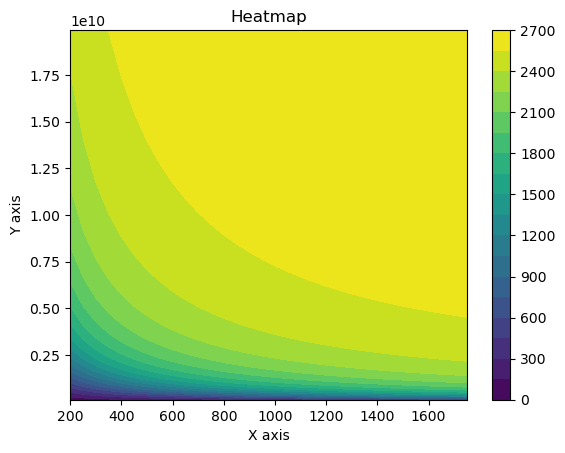

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata


x = np.arange(L1,L2,dL)
y = np.arange(l1,l2,dl) 
z = SNRlist2

# 创建网格数据
# xi = np.linspace(min(x), max(x),len(x))/1e9
# yi = np.linspace(min(y), max(y),len(y))
xi, yi = np.meshgrid(y, x)
#print(xi,yi)
X=[]
Y=[]
Z=[]
# for i in range(0,len(y)):
#     for j in range(0,len(x)):
#         X=np.append(X,xi[j][i])
#         Y=np.append(Y,yi[j][i])
#         Z=np.append(Z,z[i][j])
# zi = griddata((X, Y), Z, (xi, yi), method='nearest')
# print(zi.shape)
# 创建图形
# fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
# surf=ax.plot_surface(xi,yi,z,facecolors=plt.cm.viridis(z))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim(0,30)
# 绘制曲面
# ax.plot_surface(xi, yi, z, cmap='viridis')
# ax.view_init(elev=30, azim=0)
plt.Figure
#plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.contourf(xi, yi, z, 20, cmap='viridis') 
plt.colorbar()  # 显示颜色条

# 设置标签
# ax.set_ylabel('armlength/Gm')
# ax.set_xlabel('$\lambda$/nm')
# ax.set_zlabel('SNR')
plt.title('Heatmap')
plt.xlabel('X axis')
plt.ylabel('Y axis')
# 显示图形
plt.show()

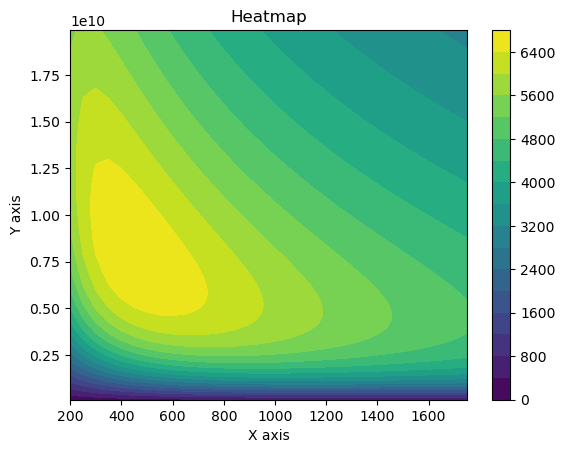

In [ ]:
L1=1*10**8
L2=20*10**9
dL=1*10**8
l1=200
l2=1800
dl=50
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata


x = np.arange(L1,L2,dL)
y = np.arange(l1,l2,dl) 
z=np.loadtxt(r'SNR_binary.txt')

# 创建网格数据
# xi = np.linspace(min(x), max(x),len(x))/1e9
# yi = np.linspace(min(y), max(y),len(y))
xi, yi = np.meshgrid(y, x)
#print(xi,yi)
X=[]
Y=[]
Z=[]
# for i in range(0,len(y)):
#     for j in range(0,len(x)):
#         X=np.append(X,xi[j][i])
#         Y=np.append(Y,yi[j][i])
#         Z=np.append(Z,z[i][j])
# zi = griddata((X, Y), Z, (xi, yi), method='nearest')
# print(zi.shape)
# 创建图形
# fig,ax=plt.subplots(subplot_kw={"projection":"3d"})
# surf=ax.plot_surface(xi,yi,z,facecolors=plt.cm.viridis(z))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim(0,30)
# 绘制曲面
# ax.plot_surface(xi, yi, z, cmap='viridis')
# ax.view_init(elev=30, azim=0)
plt.Figure
#plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.contourf(xi, yi, z, 20, cmap='viridis') 
plt.colorbar()  # 显示颜色条

# 设置标签
# ax.set_ylabel('armlength/Gm')
# ax.set_xlabel('$\lambda$/nm')
# ax.set_zlabel('SNR')
plt.title('Heatmap')
plt.xlabel('X axis')
plt.ylabel('Y axis')
# 显示图形
plt.show()